What if you need to tackle a very complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper DNN, per‐ haps with 10 layers or much more, each containing hundreds of neurons, connected by hundreds of thousands of connections, and that could not be easy:

- First, we'll be faced with the tricky vanishing gradients problem (or the related exploding gradients problem) that affects deep neural networks and makes lower layers very hard to train.

- Second, we might not have enough training data for such a large network, or it might be too costly to label.

- Third, training may be extremely slow.

- Fourth, a model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances, or they are too noisy.



In [1]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# output stable across runs
np.random.seed(42)

# plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## 1. Vanishing/ Exploding gradients problems

The backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem.

In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients prob‐ lem, which is mostly encountered in recurrent neural networks.

More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

Around 2010 significant progress was made in understanding this problems by Xavier Glorot and Yoshua Bengio. They found that the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time, namely random initialization using a normal distribution with a mean of 0 and a standard deviation of 1, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).



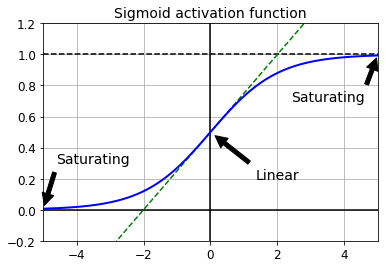

In [2]:
# function
def logit(z):
    return 1 / (1 + np.exp(-z))

# data
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

We can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus when backpropagation kicks in, it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

##### Glorot and He initialization

Glorot and Bengio propose a way to significantly alleviate this problem. We need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate.

The authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we also need the gradients to have equal variance before and after flowing through a layer in the reverse direction. It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the fan-in and fan-out of the layer), but they proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly.

By default, Keras uses Glorot initialization with a uniform distribution. We can change this to He initialization by setting kernel_initializer="he_uniform" or ker nel_initializer="he_normal" when creating a layer.



In [3]:
# initializations
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

##### Nonsaturating activation functions

It turns out that other activation functions behave much better in deep neural networks, in particular the ReLU activation function, mostly because it does not saturate for positive values (and also because it is quite fast to compute).

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, some neurons effectively die, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate.

A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting 0s, and gradient descent does not affect it anymore since the gradient of the ReLU function is 0 when its input is negative.

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU.

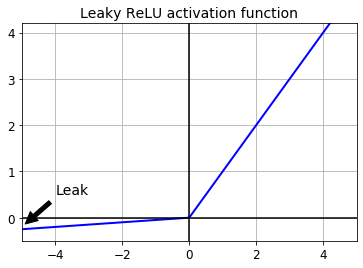

In [4]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0, and is typically set to 0.01. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up.

A new activation function was proposed called the exponential linear unit (ELU) that outperformed all the ReLU variants in their experiments: training time was reduced and the neural network performed better on the test set.

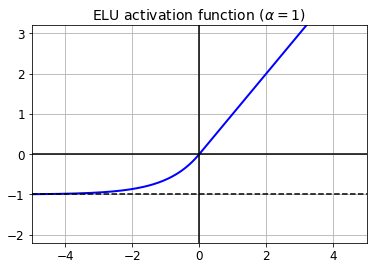

In [5]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

It looks a lot like the ReLU function, with a few major differences:

- First it takes on negative values when z < 0, which allows the unit to have an average output closer to 0. This helps alleviate the vanishing gradients problem. The hyperparameter α defines the value that the ELU function approaches when z is a large negative number.

- Second, it has a nonzero gradient for z < 0, which avoids the dead neurons problem.

- Third, if α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent, since it does not bounce as much left and right of z = 0.

The main drawback of the ELU activation function is that it is slower to compute than the ReLU and its variants (due to the use of the exponential function), but during training this is compensated by the faster convergence rate.



In [6]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

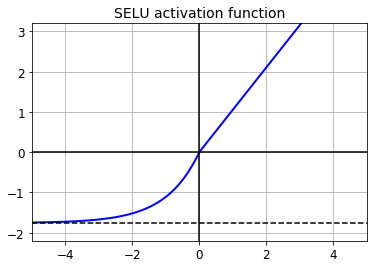

In [7]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

This activation function was proposed by Günter Klambauer, Thomas Unterthiner and Andreas Mayr. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. 

Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers.

In [8]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


So which activation function should we use for the hidden layers of your deep neural networks? Although our mileage will vary, in general SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic. If the network’s architecture prevents it from self-normalizing, then ELU may perform better than SELU (since SELU is not smooth at z = 0). If we care a lot about runtime latency, then we may go leaky ReLU.

##### Batch normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

Sergey Ioffe and Christian Szegedy proposed a technique called Batch Normalization (BN) to address the vanishing/exploding gradients problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer, simply zero-centering and normalizing each input, then scaling and shifting the result using two new parameter vectors per layer: one for scaling, the other for shifting.

In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler): the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of each input over the current mini-batch.

We may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed (IID), so computing statistics over the batch instances would be unreliable (during training, the batches should not be too small, if possible more than 30 instances, and all instances should be IID).

One solution could be to wait until the end of training, then run the whole training set through the neural network, and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations can then be used instead of the batch input means and standard deviations when making predictions.

However, it is often preferred to estimate these final statistics during training using a moving average of the layer’s input means and standard deviations.

To sum up, four parameter vectors are learned in each batch-normalized layer: γ (the ouput scale vector) and β (the output offset vector) are learned through regular backpropagation, and μ (the final input mean vector), and σ (the final input standard deviation vector) are estimated using an exponential moving average.

Batch Normalization does add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer.

##### Implementing batch normalization with Keras



In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

We can see that each BN layer adds 4 parameters per input: γ, β, μ and σ (for example, the first BN layer adds 3136 parameters, which is 4 times 784). The last two parameters, μ and σ, are the moving averages, they are not affected by backpropagation, so Keras calls them “Non-trainable” (if you count the total number of BN parameters, 3136 + 1200 + 400, and divide by two, you get 2,368, which is the total number of non-trainable params in this model).

In [11]:
# parameters of the first BN layer. Two are trainable (by backprop), and two are not
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

When we create a BN layer in Keras, it also creates two operations that will be called by Keras at each iteration during training. These operations will update the moving averages. Since we are using the TensorFlow backend, these operations are TensorFlow operations.

In [12]:
model.layers[1].updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

To add the BN layers before the activation functions (instead of after, as we've done), we must remove the activation function from the hidden layers, and add them as separate layers after the BN layers. Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass use_bias=False when creating it).

In [13]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]), keras.layers.BatchNormalization(),
keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False), keras.layers.BatchNormalization(),
keras.layers.Activation("elu"),
keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False), keras.layers.Activation("elu"),
keras.layers.BatchNormalization(),
keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30000     
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

The BatchNormalization class has quite a few hyperparameters we can tweak. The defaults will usually be fine, but we may occasionally need to tweak the momentum.

A good momentum value is typically close to 1 — for example, 0.9, 0.99, or 0.999 (we want more 9s for larger datasets and smaller mini-batches).

Another important hyperparameter is axis: it determines which axis should be normalized. It defaults to –1, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the other axes).

##### Gradient clipping

Another popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold.

This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs.

For other types of networks, BN is usually sufficient.

In Keras, implementing Gradient Clipping is just a matter of setting the clipvalue or clipnorm argument when creating an optimizer.

In [15]:
optimizer = keras.optimizers.SGD(clipvalue=1.0) 
model.compile(loss="mse", optimizer=optimizer)

This will clip every component of the gradient vector to a value between –1.0 and 1.0. This means that all the partial derivatives of the loss (with regards to each and every trainable parameter) will be clipped between –1.0 and 1.0. The threshold is a hyperparameter we can tune.

If we want to ensure that Gradient Clipping does not change the direction of the gradient vector, we should clip by norm by setting clipnorm instead of clipvalue. This will clip the whole gradient if its l2 norm is greater than the threshold you picked.

##### Reusing pretrained layers

It is generally not a good idea to train a very large DNN from scratch: instead, we should always try to find an existing neural network that accomplishes a similar task to the one we are trying to tackle, then just reuse the lower layers of this network: this is called transfer learning. It will not only speed up training considerably, but will also require much less training data.

If the input pictures of your new task don’t have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model. More generally, transfer learning will work best when the inputs have similar low-level features.

The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. 

The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, you can try keeping all the hidden layers and just replace the output layer.

##### Transfer learning with Keras

Suppose the fashion MNIST dataset only contained 8 classes, for example all classes except for sandals and shirts. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this model A. We now want to tackle a different task: we have images of sandals and shirts, and we want to train a binary classifier (positive=shirts, negative=sandals). 

However, our dataset is quite small, we only have 200 labeled images. When we train a new model for this task (let’s call it model B), with the same architecture as model A, it performs reasonably well (97.2% accuracy), but since it’s a much easier task (there are just 2 classes), we were hoping for more.

Let's split the fashion MNIST training set in two:

- X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
- X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

Since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

In [16]:
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42)

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

In [17]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [18]:
print(X_train_A.shape)
print(X_train_B.shape)

(35998, 28, 28)
(200, 28, 28)


In [19]:
print(y_train_A[:30])
print(y_train_B[:30])

[6 7 3 6 0 5 7 4 0 3 1 6 5 6 7 5 3 4 7 6 5 1 0 5 7 6 7 3 7 7]
[1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 0.]


In [20]:
tf.random.set_seed(42)
np.random.seed(42)

First, we load model A, and create a new model based on the model A’s layers. Let’s reuse all layers except for the output layer:

In [21]:
# model A
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))

for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation='selu'))
model_A.add(keras.layers.Dense(8, activation='softmax'))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
model_A.compile(loss='sparse_categorical_crossentropy',
               optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=['accuracy'])

In [23]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                     validation_data=(X_valid_A, y_valid_A))

Train on 35998 samples, validate on 12002 samples
Epoch 1/20
35998/35998 [==============================] - 7s 188us/sample - loss: 1.3264 - accuracy: 0.8164 - val_loss: 0.3911 - val_accuracy: 0.8605
Epoch 2/20
35998/35998 [==============================] - 5s 153us/sample - loss: 0.3508 - accuracy: 0.8782 - val_loss: 0.3766 - val_accuracy: 0.8713
Epoch 3/20
35998/35998 [==============================] - 6s 155us/sample - loss: 0.3055 - accuracy: 0.8939 - val_loss: 0.3155 - val_accuracy: 0.8907
Epoch 4/20
35998/35998 [==============================] - 5s 142us/sample - loss: 0.2775 - accuracy: 0.9040 - val_loss: 0.3113 - val_accuracy: 0.8929
Epoch 5/20
35998/35998 [==============================] - 6s 154us/sample - loss: 0.2577 - accuracy: 0.9096 - val_loss: 0.3027 - val_accuracy: 0.8960
Epoch 6/20
35998/35998 [==============================] - 5s 147us/sample - loss: 0.2426 - accuracy: 0.9159 - val_loss: 0.2867 - val_accuracy: 0.9013
Epoch 7/20
35998/35998 [==========================

In [24]:
model_A.save('model_A.h5')

In [25]:
# model B
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))

for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation='selu'))
model_B.add(keras.layers.Dense(1, activation='sigmoid'))

In [26]:
model_B.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=['accuracy'])

In [27]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                     validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 2998 samples
Epoch 1/20
200/200 [==============================] - 1s 7ms/sample - loss: 14.0657 - accuracy: 0.6150 - val_loss: 0.5788 - val_accuracy: 0.9353
Epoch 2/20
200/200 [==============================] - 0s 1ms/sample - loss: 0.7139 - accuracy: 0.9550 - val_loss: 0.1833 - val_accuracy: 0.9723
Epoch 3/20
200/200 [==============================] - 0s 1ms/sample - loss: 0.2133 - accuracy: 0.9700 - val_loss: 0.1347 - val_accuracy: 0.9803
Epoch 4/20
200/200 [==============================] - 0s 1ms/sample - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1271 - val_accuracy: 0.9797
Epoch 5/20
200/200 [==============================] - 0s 1ms/sample - loss: 2.6012e-04 - accuracy: 1.0000 - val_loss: 0.1269 - val_accuracy: 0.9800
Epoch 6/20
200/200 [==============================] - 0s 1ms/sample - loss: 2.1422e-04 - accuracy: 1.0000 - val_loss: 0.1268 - val_accuracy: 0.9797
Epoch 7/20
200/200 [==============================] - 0s 1ms/sample - loss: 1.79

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30000     
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

In [29]:
model_A =keras.models.load_model('model_A.h5')
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))


Note that model_A and model_B_on_A now share some layers. When we train model_B_on_A, it will also affect model_A. If we want to avoid that, we need to clone model_A before we reuse its layers. To do this, we must clone model A’s architecture, then copy its weights (since clone_model() does not clone the weights):

In [30]:
model_A_clone =keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Now we could just train model_B_on_A for task B, but since the new output layer was initialized randomly, it will make large errors, at least during the first few epochs, so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights.

In [31]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable=False
    
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

Next, we can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

In [32]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 2998 samples
Epoch 1/4
200/200 [==============================] - 1s 5ms/sample - loss: 0.4924 - accuracy: 0.8200 - val_loss: 0.4829 - val_accuracy: 0.8175
Epoch 2/4
200/200 [==============================] - 0s 1ms/sample - loss: 0.4137 - accuracy: 0.8400 - val_loss: 0.4202 - val_accuracy: 0.8426
Epoch 3/4
200/200 [==============================] - 0s 1ms/sample - loss: 0.3603 - accuracy: 0.8400 - val_loss: 0.3741 - val_accuracy: 0.8619
Epoch 4/4
200/200 [==============================] - 0s 1ms/sample - loss: 0.3199 - accuracy: 0.8450 - val_loss: 0.3290 - val_accuracy: 0.8793
Train on 200 samples, validate on 2998 samples
Epoch 1/16
200/200 [==============================] - 1s 6ms/sample - loss: 0.1743 - accuracy: 0.9300 - val_loss: 0.1113 - val_accuracy: 0.9610
Epoch 2/16
200/200 [==============================] - 0s 1ms/sample - loss: 0.0627 - accuracy: 0.9850 - val_loss: 0.0860 - val_accuracy: 0.9670
Epoch 3/16
200/200 [==========================

In [33]:
model_B.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.10146009735178313, 0.982]

In [34]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.04308746880479157, 0.986]

In [35]:
# error rate dropped:
(100 - 98.20) / (100 - 98.60)

1.2857142857142785

##### Unsupervised pretraining

Suppose we want to tackle a complex task for which we don’t have much labeled training data, but unfortunately we cannot find a model trained on a similar task.

First, we should of course try to gather more labeled training data, but if this is too hard or too expensive, we may still be able to perform unsupervised pretraining.

It is often rather cheap to gather unlabeled training examples, but quite expensive to label them. If you can gather plenty of unlabeled training data, you can try to train the layers one by one, starting with the lowest layer and then going up, using an unsupervised feature detector algorithm such as Restricted Boltzmann Machines or autoencoders.

Each layer is trained on the output of the previously trained layers (all layers except the one being trained are frozen). Once all layers have been trained this way, you can add the output layer for your task, and fine-tune the final network using supervised learning. At this point, you can unfreeze all the pretrained layers, or just some of the upper ones.

##### Pretraining on an auxiliary task

If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

For example, if you want to build a system to recognize faces, you may only have a few pictures of each individual, clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. However, you could gather a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person.

For natural language processing (NLP) applications, you can easily download millions of text documents and automatically generate labeled data from it. For example, you could randomly mask out some words and train a model to predict what the missing words are. If you can train a model to reach good performance on this task, then it will already know quite a lot about language, and you can certainly reuse it for your actual task, and fine-tune it on your labeled data.

## 2. Faster optimizers

So far we have seen four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using Batch Normalization, and reusing parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning). Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer.

##### Momentum optimization

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector m (multiplied by the learning rate η), and it updates the weights by simply adding this momentum vector. 

In other words, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, simply called the momentum, which must be set between 0 (high friction) and 1 (no friction).

For example, if β = 0.9, then the 1−β terminal velocity is equal to 10 times the gradient times the learning rate, so Momentum optimization ends up going 10 times faster than Gradient Descent. This allows Momentum optimization to escape from plateaus much faster than Gradient Descent.

Gradient Descent goes down the steep slope quite fast, but then it takes a very long time to go down the valley. In contrast, Momentum optimization will roll down the valley faster and faster until it reaches the bottom (the optimum).

In [36]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

##### Nesterov accelerated gradient

The idea of Nesterov Momentum optimization, or Nesterov Accelerated Gradient (NAG), is to measure the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum. The only difference from vanilla Momentum optimization is that the gradient is measured at θ + βm rather than at θ.

Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular Momentum optimization.



In [37]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

##### AdaGrad

The AdaGrad algorithm corrects its direction to point a bit more toward the global optimum. It achieves this by scaling down the gradient vector along the steepest dimensions. In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. An additional benefit is that it requires much less tuning of the learn‐ ing rate hyperparameter η.

The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an Adagrad optimizer, we should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression).

##### RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training).



In [38]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

##### Adam and Nadam optimization

Adaptive moment estimation, combines the ideas of Momentum optimization and RMSProp: just like Momentum optimization it keeps track of an exponentially decaying average of past gradients, and just like RMSProp it keeps track of an exponentially decaying average of past squared gradients.



In [39]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

##### Learning rate scheduling

We can do better than a constant learning rate: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called learning schedules.

- Power scheduling: The learning rate drops at each step, and after s steps it is down to η0 / 2. After s more steps, it is down to η0 / 3. Then down to η0 / 4, then η0 / 5, and so on. As we can see, this schedule first drops quickly, then more and more slowly.

- Exponential scheduling:  While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

- Piecewise constant scheduling: Use a constant learning rate for a number of epochs (e.g., η0 = 0.1 for 5 epochs), then a smaller learning rate for another number of epochs.

- Performance scheduling: Measure the validation error every N steps (just like for early stopping) and reduce the learning rate by a factor of λ when the error stops dropping.

Implementing power scheduling in Keras is the easiest option: just set the decay hyperparameter when creating an optimizer. The decay is the inverse of s (the number of steps it takes to divide the learning rate by one more unit).

In [40]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

Now, let’s implement exponential scheduling:

In [41]:
def exponential_decay_fn(epoch): 
    return 0.01 * 0.1**(epoch / 20)

In [42]:
# function that returns a configured function (no hard coding!)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [43]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [44]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 10s 219us/sample - loss: 0.8311 - accuracy: 0.7595 - val_loss: 0.7668 - val_accuracy: 0.7997
Epoch 2/25
45000/45000 [==============================] - 10s 221us/sample - loss: 0.6604 - accuracy: 0.8014 - val_loss: 0.8536 - val_accuracy: 0.7666
Epoch 3/25
45000/45000 [==============================] - 9s 205us/sample - loss: 0.6038 - accuracy: 0.8172 - val_loss: 0.7046 - val_accuracy: 0.7789
Epoch 4/25
45000/45000 [==============================] - 9s 207us/sample - loss: 0.4984 - accuracy: 0.8437 - val_loss: 1.0107 - val_accuracy: 0.7147
Epoch 5/25
45000/45000 [==============================] - 10s 230us/sample - loss: 0.4877 - accuracy: 0.8497 - val_loss: 0.7438 - val_accuracy: 0.8232
Epoch 6/25
45000/45000 [==============================] - 11s 239us/sample - loss: 0.4329 - accuracy: 0.8601 - val_loss: 0.5038 - val_accuracy: 0.8606
Epoch 7/25
45000/45000 [======================

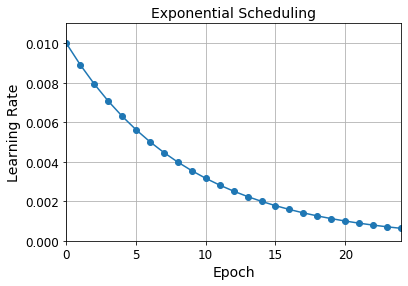

In [45]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [46]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

If we want to update the learning rate at each iteration rather than at each epoch, we must write your own callback class:

In [47]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 11s 240us/sample - loss: 0.8047 - accuracy: 0.7664 - val_loss: 0.9963 - val_accuracy: 0.7496
Epoch 2/25
45000/45000 [==============================] - 10s 229us/sample - loss: 0.6571 - accuracy: 0.7999 - val_loss: 0.6661 - val_accuracy: 0.7873
Epoch 3/25
45000/45000 [==============================] - 10s 227us/sample - loss: 0.5920 - accuracy: 0.8214 - val_loss: 1.0519 - val_accuracy: 0.6760
Epoch 4/25
45000/45000 [==============================] - 10s 233us/sample - loss: 0.5213 - accuracy: 0.8356 - val_loss: 0.6041 - val_accuracy: 0.8138
Epoch 5/25
45000/45000 [==============================] - 10s 224us/sample - loss: 0.4792 - accuracy: 0.8513 - val_loss: 0.7166 - val_accuracy: 0.8377
Epoch 6/25
45000/45000 [==============================] - 11s 247us/sample - loss: 0.4246 - accuracy: 0.8621 - val_loss: 0.4645 - val_accuracy: 0.8573
Epoch 7/25
45000/45000 [====================

In [48]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

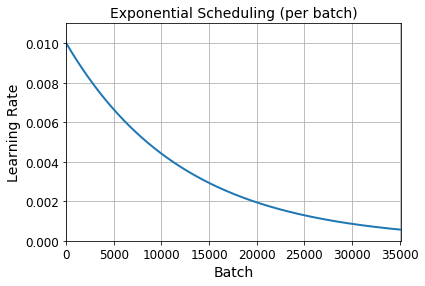

In [49]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

For piecewise constant scheduling, we can use a schedule function like the following one (as earlier, we can define a more general function if you want, see the notebook for an example), then create a LearningRateScheduler callback with this function and pass it to the fit() method, just like we did for exponential scheduling:

In [50]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [51]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [52]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 12s 259us/sample - loss: 0.8530 - accuracy: 0.7556 - val_loss: 1.0561 - val_accuracy: 0.7563
Epoch 2/25
45000/45000 [==============================] - 10s 222us/sample - loss: 0.7013 - accuracy: 0.7886 - val_loss: 0.9305 - val_accuracy: 0.7921
Epoch 3/25
45000/45000 [==============================] - 10s 211us/sample - loss: 0.9415 - accuracy: 0.7269 - val_loss: 0.9496 - val_accuracy: 0.6355
Epoch 4/25
45000/45000 [==============================] - 10s 215us/sample - loss: 0.8658 - accuracy: 0.7587 - val_loss: 0.9549 - val_accuracy: 0.6910
Epoch 5/25
45000/45000 [==============================] - 9s 206us/sample - loss: 1.0358 - accuracy: 0.7014 - val_loss: 1.3103 - val_accuracy: 0.5208
Epoch 6/25
45000/45000 [==============================] - 10s 216us/sample - loss: 0.7635 - accuracy: 0.7241 - val_loss: 0.6848 - val_accuracy: 0.7606
Epoch 7/25
45000/45000 [=====================

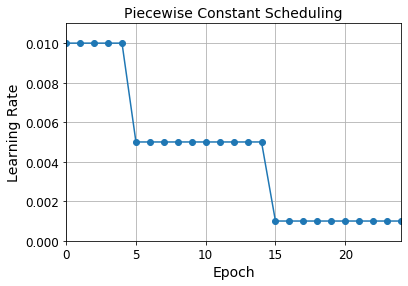

In [53]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## 3. Avoiding overfitting through regularization

Deep neural networks typically have tens of thousands of parameters, sometimes even millions. With so many parameters, the network has an incredible amount of freedom and can fit a huge variety of complex datasets. But this great flexibility also means that it is prone to overfitting the training set.

We've already used great regularization techniques, namely early stopping and batch normalization. Let's explore some more.

##### l1 and l2 regularizations

We can use l1 and l2 regularization to constrain a neural network’s connection weights (but typically not its bia‐ ses).

In [54]:
# applying l2 regularization to a Keras layer’s connection weights, using a regularization factor of 0.01
layer = keras.layers.Dense(100, activation='elu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [55]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 45000 samples, validate on 15000 samples
Epoch 1/2
45000/45000 [==============================] - 10s 226us/sample - loss: 1.8140 - accuracy: 0.8106 - val_loss: 0.7645 - val_accuracy: 0.8149
Epoch 2/2
45000/45000 [==============================] - 9s 209us/sample - loss: 0.7295 - accuracy: 0.8212 - val_loss: 0.7670 - val_accuracy: 0.8077


The l2() function returns a regularizer that will be called to compute the regularization loss, at each step during training. This regularization loss is then added to the final loss.

Since you will typically want to apply the same regularizer to all layers in your network, as well as the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments over and over. This makes it ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python’s functools.partial() function: it lets you create a thin wrapper for any callable, with some default argument values.

In [56]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense, 
                           activation="elu",
                           kernel_initializer="he_normal", 
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([ keras.layers.Flatten(input_shape=[28, 28]), 
                                 RegularizedDense(300), 
                                 RegularizedDense(100), 
                                 RegularizedDense(10, 
                                 activation="softmax",
                                 kernel_initializer="glorot_uniform")
])
                                

##### Dropout

At every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step. 

The hyperparameter p is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore.

In [57]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 45000 samples, validate on 15000 samples
Epoch 1/2
45000/45000 [==============================] - 12s 263us/sample - loss: 0.5914 - accuracy: 0.7990 - val_loss: 0.3856 - val_accuracy: 0.8587
Epoch 2/2
45000/45000 [==============================] - 10s 213us/sample - loss: 0.4280 - accuracy: 0.8440 - val_loss: 0.3868 - val_accuracy: 0.8581


Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step. Since each neuron can be either present or absent, there is a total of 2N possible networks (where N is the total number of drop‐ pable neurons). This is such a huge number that it is virtually impossible for the same neural network to be sampled twice.

There is one small but important technical detail. Suppose p = 50%, in which case during testing a neuron will be connected to twice as many input neurons as it was (on average) during training. To compensate for this fact, we need to multiply each neuron’s input connection weights by 0.5 after training. If we don’t, each neuron will get a total input signal roughly twice as large as what the network was trained on, and it is unlikely to perform well. More generally, we need to multiply each input connection weight by the keep probability (1 – p) after training.

Since dropout is only active during training, the training loss is penalized compared to the validation loss, so comparing the two can be misleading. In particular, a model may be overfitting the training set and yet have similar training and validation losses. So make sure to evaluate the training loss without dropout (e.g., after training).

In [58]:
model.evaluate(X_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.41381978726387025, 0.8497]

In [59]:
model.evaluate(X_train_scaled, y_train)

45000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.34631861442989775, 0.8676222]

In [60]:
history = model.fit(X_train_scaled, y_train)

Train on 45000 samples
45000/45000 [==============================] - 8s 186us/sample - loss: 0.3927 - accuracy: 0.8550


If we want to regularize a self-normalizing network based on the SELU activation function (as discussed earlier), we should use AlphaDropout: this is a variant of dropout that preserves the mean and standard deviation of its inputs.

##### MonteCarlo dropout

We first force training mode on, using a learning_phase_scope(1) context. This turns dropout on within the with block. Then we make 100 predictions over the test set, and we stack them. Since dropout is on, all predictions will be different. Recall that predict() returns a matrix with one row per instance, and one column per class.

In [61]:
with keras.backend.learning_phase_scope(1): # force training mode = dropout on 
    y_probas = np.stack([model.predict(X_test_scaled)
                for sample in range(100)]) 

y_proba = y_probas.mean(axis=0)

Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout off. For example, let’s look at the model’s prediction for the first instance in the test set, with dropout off:

In [62]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],
      dtype=float32)

The model seems almost certain that this image belongs to class 9; let's compare with the model with dropout activated:

In [64]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0

This tells a very different story: apparently, when we activate dropout, the model is not sure anymore. It still seems to prefer class 9, but sometimes it hesitates with classes 5 (sandal) and 7 (sneaker), which makes sense given they’re all footwear. Once we average over the first dimension, we get the following MC dropout predictions:

In [65]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.9 ]],
      dtype=float32)

The number of Monte Carlo samples you use (100 in this example) is a hyperparameter you can tweak. The higher it is, the more accurate the predictions and their uncertainty estimates will be. However, if we double it, inference time will also be doubled.